# Chromatographic Processes - Exercise

## Exercise 1: Combine nonbinding tracer with binding components

From the tutorial, combine the dextran pulse with the langmuir experiment.
Then, start modifying:
- Feed concentrations
- Adsorption parameters
- Transport parameters
- Flow Rates

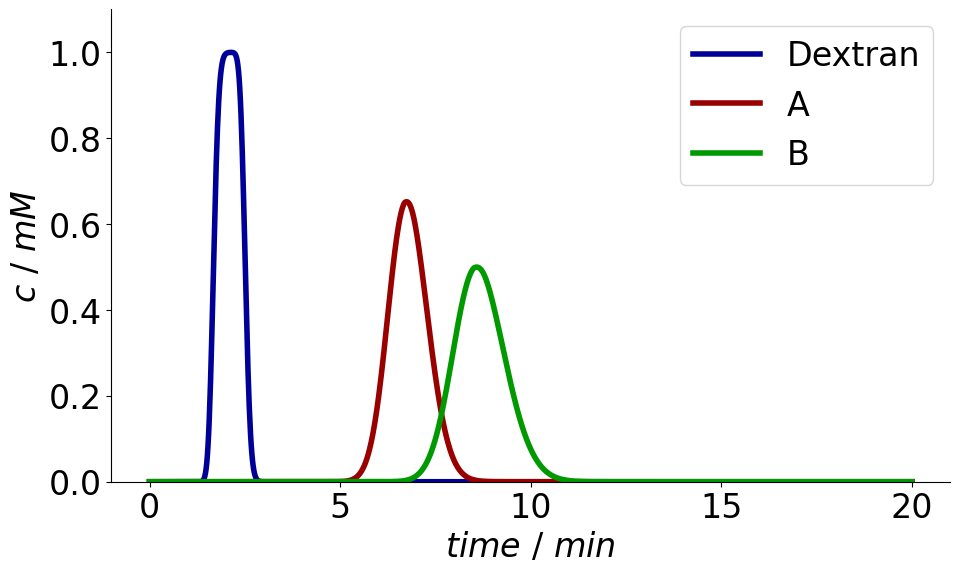

In [1]:
from CADETProcess.processModel import ComponentSystem
from CADETProcess.processModel import Langmuir
from CADETProcess.processModel import Inlet, LumpedRateModelWithPores, Outlet
from CADETProcess.processModel import FlowSheet
from CADETProcess.processModel import Process

# Component System
component_system = ComponentSystem()
component_system.add_component('Dextran')
component_system.add_component('A')
component_system.add_component('B')

# Binding Model
binding_model = Langmuir(component_system, name='langmuir')
binding_model.is_kinetic = False
binding_model.adsorption_rate = [0, 0.02, 0.03]
binding_model.desorption_rate = [1, 1, 1]
binding_model.capacity = [100, 100, 100]

inlet = Inlet(component_system, 'inlet')
inlet.flow_rate = 2.88e-8

column = LumpedRateModelWithPores(component_system, 'column')
column.binding_model = binding_model
column.length = 0.1
column.diameter = 0.01
column.bed_porosity = 0.37
column.particle_radius = 4.5e-5
column.particle_porosity = 0.33
column.axial_dispersion = 2.0e-7
column.film_diffusion = [0, 1e-4, 1e-4]

outlet = Outlet(component_system, 'outlet')

flow_sheet = FlowSheet(component_system)
flow_sheet.add_unit(inlet)
flow_sheet.add_unit(column)
flow_sheet.add_unit(outlet)

flow_sheet.add_connection(inlet, column)
flow_sheet.add_connection(column, outlet)

process = Process(flow_sheet, 'dextran')
process.cycle_time = 1200

process.add_event('inject_on', 'flow_sheet.inlet.c', [1.0, 1.0, 1.0], 0)
process.add_event('inject_off', 'flow_sheet.inlet.c', [0.0, 0.0, 0.0], 50.0)

from CADETProcess.simulator import Cadet
simulator = Cadet()

simulation_results = simulator.simulate(process)

_ = simulation_results.solution.column.outlet.plot()

## Exercise 2: Multiple injections

For some processes, multiple injections onto a column in sequence.
Take the previous example and create an inlet profile with three injections.
For this purpose, the `Simulator` can automatically run multiple simulations by setting `n_cycles`.

***Task:*** Try finding the best interval (cycle time) s.t. the column is used most efficiently.

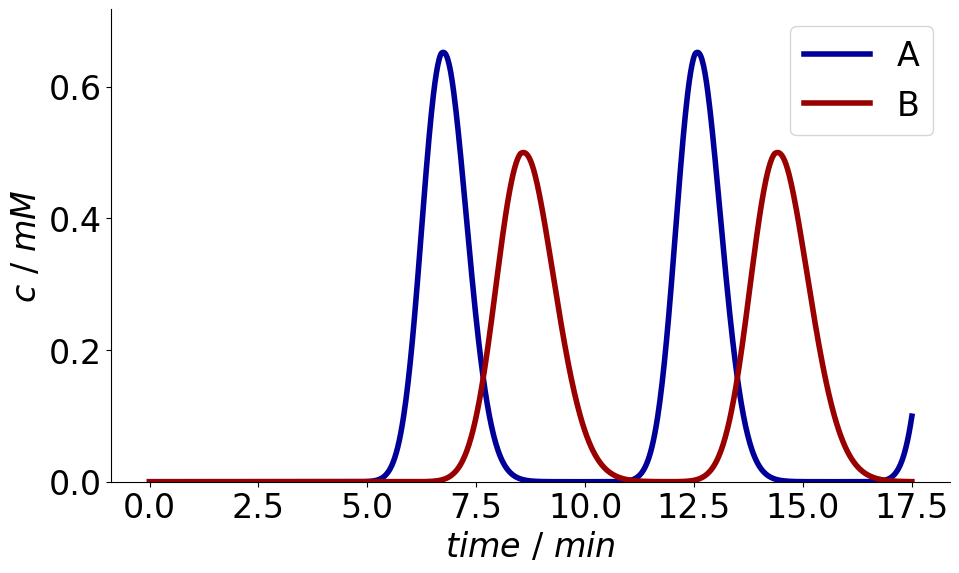

In [2]:
from CADETProcess.processModel import ComponentSystem
from CADETProcess.processModel import Langmuir
from CADETProcess.processModel import Inlet, LumpedRateModelWithPores, Outlet
from CADETProcess.processModel import FlowSheet
from CADETProcess.processModel import Process

# Component System
component_system = ComponentSystem()
component_system.add_component('A')
component_system.add_component('B')

# Binding Model
binding_model = Langmuir(component_system, name='langmuir')
binding_model.is_kinetic = False
binding_model.adsorption_rate = [0.02, 0.03]
binding_model.desorption_rate = [1, 1]
binding_model.capacity = [100, 100]

inlet = Inlet(component_system, 'inlet')
inlet.flow_rate = 2.88e-8

column = LumpedRateModelWithPores(component_system, 'column')
column.binding_model = binding_model
column.length = 0.1
column.diameter = 0.01
column.bed_porosity = 0.37
column.particle_radius = 4.5e-5
column.particle_porosity = 0.33
column.axial_dispersion = 2.0e-7
column.film_diffusion = [1e-4, 1e-4]

outlet = Outlet(component_system, 'outlet')

flow_sheet = FlowSheet(component_system)
flow_sheet.add_unit(inlet)
flow_sheet.add_unit(column)
flow_sheet.add_unit(outlet)

flow_sheet.add_connection(inlet, column)
flow_sheet.add_connection(column, outlet)

process = Process(flow_sheet, 'dextran')
process.cycle_time = 350

process.add_event('inject_on', 'flow_sheet.inlet.c', [1.0, 1.0], 0)
process.add_event('inject_off', 'flow_sheet.inlet.c', [0.0, 0.0], 50.0)

from CADETProcess.simulator import Cadet
simulator = Cadet()
simulator.n_cycles = 3

simulation_results = simulator.simulate(process)

_ = simulation_results.solution.column.outlet.plot()

## Example 3: Load wash elute with three components

Add a second protein component to the LWE example from the tutorial lesson.
Assume that all parameters are the same as the first protein, only change:
- adsorption rate: $0.3~m^{3}_{MP}m^{-3}_{SP}s^{-1}$
- characteristic charge: $5.0$

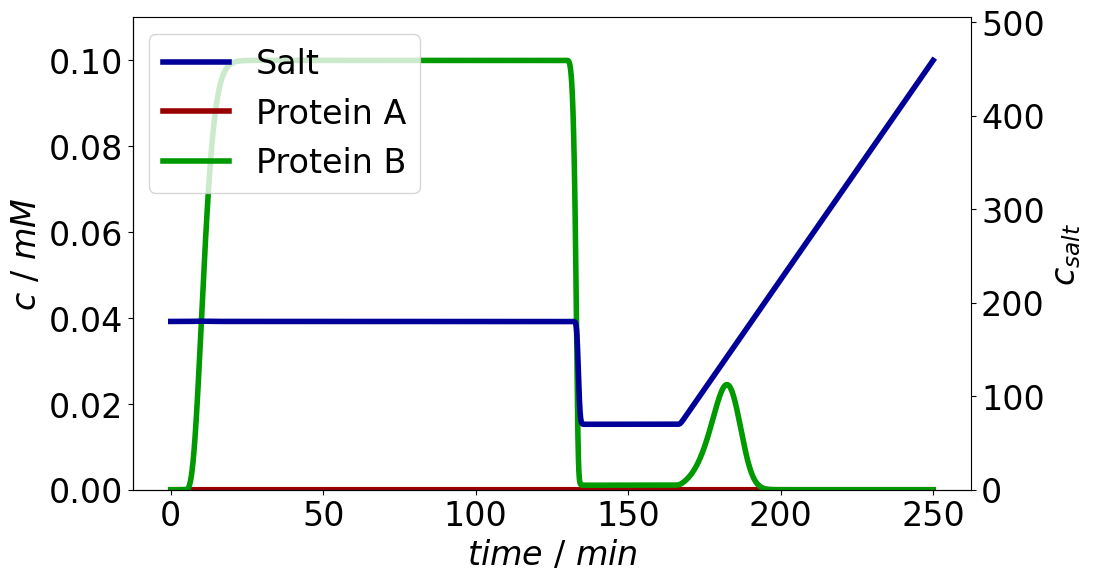

In [3]:
import numpy as np

from CADETProcess.processModel import ComponentSystem
from CADETProcess.processModel import StericMassAction
from CADETProcess.processModel import Inlet, GeneralRateModel, Outlet
from CADETProcess.processModel import FlowSheet
from CADETProcess.processModel import Process

# Component System
component_system = ComponentSystem()
component_system.add_component('Salt')
component_system.add_component('Protein A')
component_system.add_component('Protein B')

# Binding Model
binding_model = StericMassAction(component_system, name='SMA')
binding_model.is_kinetic = True
binding_model.adsorption_rate = [0.0, 0.3, 0.2]
binding_model.desorption_rate = [0.0, 1.5, 1.5]
binding_model.characteristic_charge = [0.0, 7.0, 5.0]
binding_model.steric_factor = [0.0, 50.0, 50.0]
binding_model.capacity = 225.0
binding_model.reference_liquid_phase_conc = 300
binding_model.reference_solid_phase_conc = 225.0

# Unit Operations
inlet = Inlet(component_system, name='inlet')
inlet.flow_rate = 2.88e-8

column = GeneralRateModel(component_system, name='column')
column.binding_model = binding_model

column.length = 0.25
column.diameter = 0.0115
column.bed_porosity = 0.37
column.particle_radius = 4.5e-5
column.particle_porosity = 0.33
column.axial_dispersion = 2.0e-7
column.film_diffusion = [2.0e-5, 2.0e-7, 2.0e-7]
column.pore_diffusion = [7e-5, 1e-9, 1e-9]
column.surface_diffusion = [0.0, 0.0, 0.0]

outlet = Outlet(component_system, name='outlet')

# Flow Sheet
flow_sheet = FlowSheet(component_system)

flow_sheet.add_unit(inlet)
flow_sheet.add_unit(column)
flow_sheet.add_unit(outlet, product_outlet=True)

flow_sheet.add_connection(inlet, column)
flow_sheet.add_connection(column, outlet)

# Process
process = Process(flow_sheet, 'lwe')
process.cycle_time = 15000.0

## Create Events and Durations
wash_start = 7500.0
gradient_start = 9500.0
concentration_difference = np.array([500.0, 0.0]) - np.array([70.0, 0.0])
gradient_duration = process.cycle_time - gradient_start
gradient_slope = concentration_difference/gradient_duration

_ = process.add_event('load', 'flow_sheet.inlet.c', [180.0, 0.0, 0.1])
_ = process.add_event('wash', 'flow_sheet.inlet.c', [70.0, 0.0, 0.0], wash_start)
_ = process.add_event(
    'grad_start',
    'flow_sheet.inlet.c',
    [[70.0, gradient_slope[0]], [0, gradient_slope[1]], [0, gradient_slope[1]]],
    gradient_start
)

column.c = [180, 0, 0]
column.q = [binding_model.capacity, 0, 0]

from CADETProcess.simulator import Cadet
process_simulator = Cadet()

simulation_results = process_simulator.simulate(process)

from CADETProcess.plotting import SecondaryAxis
sec = SecondaryAxis()
sec.components = ["Salt"]
sec.y_label = '$c_{salt}$'

_ = simulation_results.solution.column.outlet.plot(secondary_axis=sec)